# Multi-modal RAG

*   Author: Sif Eddine Boudjellal
*   [LinkedIn](https://www.linkedin.com/in/sif-eddine-boudjellal/)|[Email](sifeddineboudjellal@gmail.com)




In this comprehensive guide, I demonstrate the development of a **Multi-modal Retrieval-Augmented Generation (RAG) system**. Leveraging the power of **Gemini**, **LangChain**, and **Unstructured**, this system seamlessly processes diverse document types—text, tables, and images—while retrieving accurate and relevant information. What sets this system apart is its ability to not only handle text but also include the relevant images and tables from the document in response to the input query.

Whether you're working on document analysis, knowledge retrieval, or building AI-powered tools, this guide provides a step-by-step approach to integrating multi-modal capabilities into your workflow. By combining advanced summarization techniques with efficient retrieval mechanisms, this system ensures that users get the most contextually relevant information, regardless of the data type.

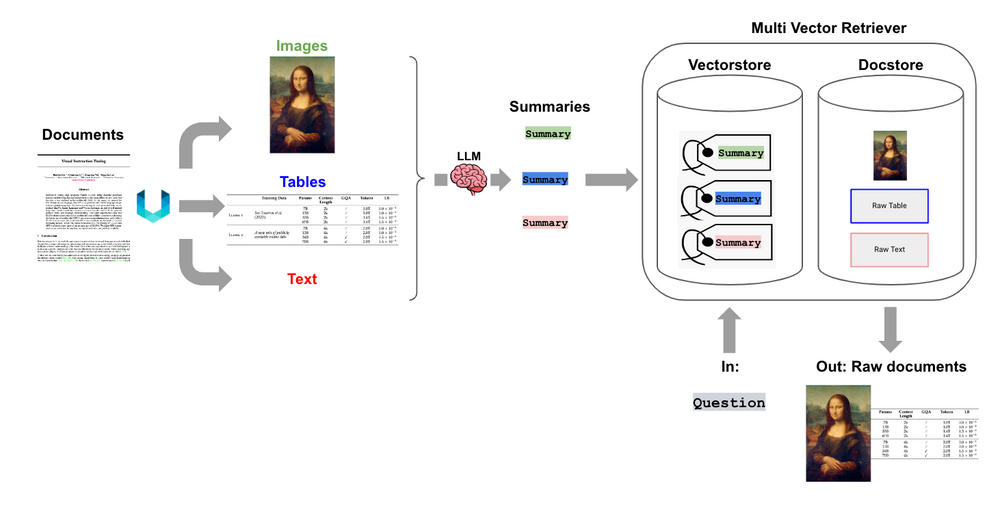

By the end of this notebook, you'll have a fully functional multi-modal RAG system that can process complex documents and provide accurate, context-aware responses to user queries. Let’s dive in!

## 1. Installation of Dependencies

### 1.1 Install Tesseract
Tesseract is an OCR (Optical Character Recognition) engine used to extract text from images. This section installs Tesseract and its development libraries.

In [ ]:
!apt-get update
!apt-get install poppler-utils
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

### 1.2 Install Required Python Packages
This section installs the necessary Python libraries for the project, including LangChain, Unstructured, and Google's Generative AI tools.

In [ ]:

!pip install langchain langchain-google-genai unstructured[all-docs] pydantic lxml google-generativeai chromadb tiktoken pytesseract Pillow moviepy

In [ ]:
!pip install -U langchain-community langchain-chroma

## 2. Importing Libraries


This section imports all the necessary Python libraries and modules required for the project, including Google's Generative AI, LangChain, Unstructured, and image processing libraries.

In [1]:

import os
import uuid
import base64
from io import BytesIO

import google.generativeai as genai
from langchain_google_genai import ChatGoogleGenerativeAI

from unstructured.partition.auto import partition
from unstructured.partition.pdf import partition_pdf  # Import for PDF-specific partitioning
from PIL import Image
import IPython.display as display

from langchain_google_genai import GoogleGenerativeAIEmbeddings
# from langchain_google_vertexai import VertexAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore

from langchain_chroma import Chroma
from langchain.schema.messages import HumanMessage, AIMessage
from dotenv import load_dotenv

from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser


## 3. Setting Up Google Generative AI


This section configures the Google Generative AI API by setting the API key and initializing the Gemini models for text and vision tasks.

In [2]:

load_dotenv()
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")
# Initialize Gemini API (ensure you have your API key set up in .env as GOOGLE_API_KEY)
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
gemini_model = "gemini-1.5-pro" # Or any other Gemini model
gemini_vision_model = "gemini-1.5-flash" # Using vision for image analysis
chain_gpt = ChatGoogleGenerativeAI(model=gemini_model, temperature=0)
chain_gpt_vision = ChatGoogleGenerativeAI(model=gemini_vision_model, temperature=0)


Enter your Google AI API key: ··········


## 4. Document Processing

### 4.1 Handling Base64 Images
This section provides utility functions to encode images to base64 strings and display them in the notebook.

In [3]:
def encode_image(image_path):
    """Encodes an image to a base64 string."""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def display_encoded_image(encoded_string):
    """Displays a base64 encoded image in a notebook."""
    try:
        image_data = base64.b64decode(encoded_string)
        image = Image.open(BytesIO(image_data))
        display.display(image)
    except Exception as e:
        print(f"Error displaying image: {e}")

### 4.2 Summarization Functions
This section defines functions to summarize text, tables, and images using the Gemini models.

In [4]:
def summarize_text(text_element):
    """Summarizes a text element using Gemini."""
    prompt = f"""
          You are an assistant tasked with summarizing text.
          Give a concise summary of the text.
          Respond only with the summary, no additionnal comment.
          Do not start your message by saying "Here is a summary" or anything like that.
          Just give the summary as it is.
          text chunk: {text_element}
          """
    response = chain_gpt.invoke([HumanMessage(content=prompt)])
    return response.content

def summarize_table(table_element):
    """Summarizes a table element using Gemini."""
    prompt = f"""
          You are an assistant tasked with summarizing tables.
          Give a concise summary of the table.
          Respond only with the summary, no additionnal comment.
          Do not start your message by saying "Here is a summary" or anything like that.
          Just give the summary as it is.
          table chunk: {table_element}
          """
    response = chain_gpt.invoke([HumanMessage(content=prompt)])
    return response.content

def summarize_image(encoded_image):
    """Summarizes an image using Gemini Vision with a focus on detailed and specific descriptions."""
    prompt_template = """Analyze the image in detail, noting that it is part of a document.
    Focus on describing visual elements, especially graphs such as bar plots, with precision and clarity."""

    prompt = [
        AIMessage(content="You are an expert at analyzing and interpreting images."),
        HumanMessage(content=[
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]

    response = chain_gpt_vision.invoke(prompt)
    return response.content


### 4.3 Document Processing Function
This function processes documents (PDF, TXT, etc.) using Unstructured, extracting text, tables, and images.

In [5]:

def process_documents(input_path, output_path, file_type):
    """Processes documents of various types (PDF, TXT, etc.) using Unstructured."""

    raw_elements = []
    if file_type == "pdf":
        raw_elements =partition_pdf(
              filename=input_path,
              infer_table_structure=True,            # extract tables
              strategy="hi_res",                     # mandatory to infer tables
              extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
              # image_output_dir_path=output_path,   # if None, images and tables will saved in base64
              extract_image_block_to_payload=True,   # if true, will extract base64 for API usage
              chunking_strategy="by_title",          # or 'basic'
              max_characters=10000,                  # defaults to 500
              combine_text_under_n_chars=2000,       # defaults to 0
              new_after_n_chars=6000,
              # extract_images_in_pdf=True,          # deprecated
          )
    else:  # For other file types like TXT, DOCX, etc.
        raw_elements = partition(filename=input_path, extract_images_in_pdf=True,
                                image_output_dir_path=output_path)


    text_elements = []
    table_elements = []
    image_elements = []

    for element in raw_elements:
        if 'CompositeElement' in str(type(element)):
            text_elements.append(element)
        elif 'Table' in str(type(element)):
            table_elements.append(element)

    table_elements = [table.metadata.text_as_html for table in table_elements] #Save the Tables in html format
    text_elements = [i.text for i in text_elements]

    # Images
    for element in raw_elements:
      if "CompositeElement" in str(type(element)):
        chunk_els = element.metadata.orig_elements
        for el in chunk_els:
            if "Image" in str(type(el)):
                image_elements.append(el.metadata.image_base64)

    print(f"The length of table elements are: {len(table_elements)}")
    print(f"The length of text elements are: {len(text_elements)}")
    print(f"The length of image elements are: {len(image_elements)}")

    return text_elements, table_elements, image_elements

## 5. Multi-modal RAG

### 5.1 Retriever Setup
This section defines functions to create a multi-vector retriever that can handle text, tables, and images

In [13]:
def create_retriever(embeddings_model):
    """Creates and configures the multi-vector retriever."""
    vectorstore = Chroma(collection_name="summaries", embedding_function=embeddings_model)
    store = InMemoryStore()
    id_key = "doc_id"
    retriever = MultiVectorRetriever(vectorstore=vectorstore, docstore=store, id_key=id_key, top_k=1)
    return retriever, id_key

def add_documents_to_retriever(retriever, summaries, original_contents, id_key):
    """Adds documents and their summaries to the retriever."""
    doc_ids = [str(uuid.uuid4()) for _ in summaries]
    summary_docs = [
        Document(page_content=s, metadata={id_key: doc_ids[i]})
        for i, s in enumerate(summaries)
    ]
    retriever.vectorstore.add_documents(summary_docs)
    retriever.docstore.mset(list(zip(doc_ids, original_contents)))

### 5.2 RAG Chain
This section defines the RAG chain that processes user queries and retrieves relevant information from the retriever.

In [14]:
from base64 import b64decode
def parse_docs(docs):
    """Split base64-encoded images and texts."""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)  # Check if the document is a valid base64 string
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}

def create_rag_chain(retriever):
    """Creates the RAG chain using Gemini, handling both text and base64-encoded images."""
    template = """Answer the question based only on the following context, which can include text and images:\n{context}\nQuestion: {question}\n"""
    prompt = ChatPromptTemplate.from_template(template)

    model = ChatGoogleGenerativeAI(model=gemini_model, temperature=0)

    chain_with_sources = {
        "context": retriever | RunnableLambda(parse_docs),  # Parse retrieved docs into images and texts
        "question": RunnablePassthrough(),  # Pass the question through
    } | RunnablePassthrough().assign(
        response=(
            prompt  # Use the prompt template
            | model  # Pass the prompt to the model
            | StrOutputParser()  # Parse the model's output as a string
        )
    )

    return chain_with_sources

### 5.3 RAG Pipeline
This class encapsulates the entire RAG pipeline, from document processing to query retrieval.

In [15]:
class RAGPipeline:
    def __init__(self, input_path, output_path, file_type):
        """
        Initializes the RAG pipeline by processing documents, generating summaries, and setting up the retriever.

        Args:
            input_path (str): Path to the input file or directory.
            output_path (str): Path to save processed outputs.
            file_type (str): Type of the input file (e.g., PDF, text, etc.).
        """
        # 1. Process Documents
        print('\nProcessing Documents...\n')
        self.text_elements, self.table_elements, self.image_elements = process_documents(input_path, output_path, file_type)
        print('\nDocument Processing Complete.\n')

        # 2. Generate Summaries
        print('\nGenerating Summaries...\n')
        # Use raw text elements if summarization is not required
        self.text_summaries = self.text_elements  # Uncomment below to generate text summaries
        # self.text_summaries = [summarize_text(text) for text in self.text_elements]

        # Use raw table elements if summarization is not required
        self.table_summaries = self.table_elements  # Uncomment below to generate table summaries
        # self.table_summaries = [summarize_table(table) for table in self.table_elements]

        # Generate image summaries (always required)
        self.image_summaries = [summarize_image(image) for image in self.image_elements]
        print('\nSummary Generation Complete.\n')

        # 3. Create Embeddings and Retriever
        print('\nCreating Embeddings and Retriever...\n')
        self.embeddings_model = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
        self.retriever, self.id_key = create_retriever(self.embeddings_model)
        print('\nEmbeddings and Retriever Setup Complete.\n')

        # 4. Add Documents to Retriever
        print('\nAdding Documents to Retriever...\n')
        if self.text_summaries:
          add_documents_to_retriever(self.retriever, self.text_summaries, self.text_elements , self.id_key)
        if self.table_summaries:
          add_documents_to_retriever(self.retriever, self.table_summaries, self.table_elements, self.id_key)
        if self.image_summaries:
          add_documents_to_retriever(self.retriever, self.image_summaries, self.image_elements, self.id_key)
        print('\nDocuments Added to Retriever.\n')

        # 5. Create RAG Chain
        print('\nSetting Up RAG Chain...\n')
        self.rag_chain = create_rag_chain(self.retriever)
        print('\nRAG Chain Setup Complete.\n')

    def retrieving(self, question, image_base64=None):
        """
        Retrieves an answer to the given question, optionally using a multimodal query with an image.

        Args:
            question (str): The question to be answered.
            image_base64 (str, optional): Base64-encoded image for multimodal queries.

        Returns:
            str: The answer to the question.
        """
        if image_base64:
            query = self.create_multimodal_query(question, image_base64)
        else:
            query = question

        print('\nRetrieving Answer...\n')
        answer = self.rag_chain.invoke(query)
        #print(f"Question: {question}")
        #print(f"Answer: {answer}\n")
        return answer

    @staticmethod
    def create_multimodal_query(text_query, image_base64=None):
        """Constructs a multimodal query with text and an optional image."""
        if image_base64:
            query = [
                {"type": "text", "text": text_query},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}
                },
            ]
        else:
            query = text_query
        return query

## 6. Testing the RAG Pipeline

In [9]:
input_path = os.getcwd()
output_path = os.path.join(os.getcwd(), "figures")

In [10]:
def retrieve_and_display(report_rag, question):
    """
    Retrieves an answer to the question using the RAG pipeline and displays the response and context.
    """
    # Retrieve the result
    result = report_rag.retrieving(question)

    # Print the question and response
    print(f"Question: {result['question']}\n\n")
    print(f"Response: {result['response']}\n\n")

    # Print the context
    print("Context:")
    print(f"- Images: {len(result['context']['images'])}\n\n")
    print(f"- Texts: {result['context']['texts']}\n\n")

    # Display images if any
    if result['context']['images']:
        for img in result['context']['images']:
            display_encoded_image(img)

### 6.1 Text-based Query
This section demonstrates how to use the RAG pipeline to answer a text-based query.

In [20]:
# Initialize the RAG pipeline
report_path = os.path.join(input_path, "/content/Graph_RAG_paper.pdf")
report_rag = RAGPipeline(report_path, output_path, "pdf")


Processing Documents...

The length of table elements are: 0
The length of text elements are: 15
The length of image elements are: 5

Document Processing Complete.


Generating Summaries...


Summary Generation Complete.


Creating Embeddings and Retriever...


Embeddings and Retriever Setup Complete.


Adding Documents to Retriever...


Documents Added to Retriever.


Setting Up RAG Chain...


RAG Chain Setup Complete.



In [21]:
question1 = "How the entity references detected in the HotPotQA dataset"
result = report_rag.retrieving(question1)


Retrieving Answer...



In [22]:
print(f"Question: {result['question']}\n\n")
print(f"Response: {result['response']}")


Question: How the entity references detected in the HotPotQA dataset


Response: Using a chunk size of 600 tokens extracted almost twice as many entity references as when using a chunk size of 2400. More references are generally better, but any extraction process needs to balance recall and precision.



- Images: 1




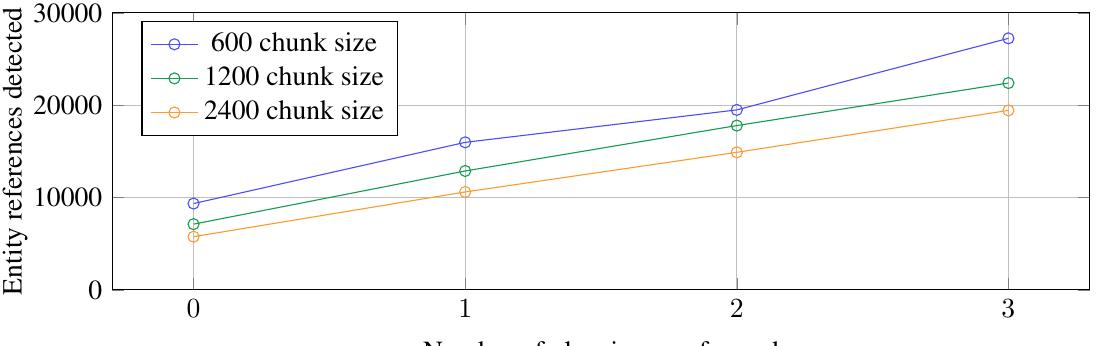

In [23]:
print(f"- Images: {len(result['context']['images'])}\n\n")

# Display images if any
for img in result['context']['images']:
    display_encoded_image(img)


Retrieving Answer...

Question: Attention Mechanisms


Response: The self-attention mechanism uses scaled dot-product attention. It calculates the dot product of query and key matrices, scales it by dK, and normalizes it with softmax to produce attention weights.  These weights are then applied to the value matrix to generate the output.  Multi-head attention improves this by using multiple heads to attend to different input aspects in parallel, concatenating the results. Each head processes a subspace of the input, enabling the model to capture diverse patterns.  Figure 1 shows both self-attention and multi-head attention mechanisms.



Context:
- Images: 1


- Texts: ['III. METHODOLOGY\n\nThis section outlines the methodological framework of our study, detailing transformer architectures, their role in computer vision, and the integration of hybrid convolutional transformers for accurate finger vein (FV) image classification and recognition.\n\nA. Transformer Architecture\n\nInitial

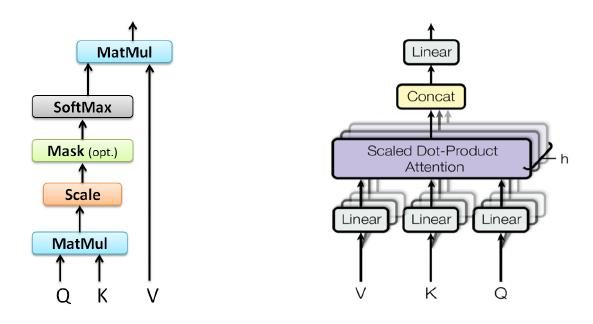

In [19]:
retrieve_and_display(report_rag, "Attention Mechanisms")

### 6.2 Multimodal Query (Text + Image)
This section demonstrates how to use the RAG pipeline to answer a multimodal query that includes both text and an image.

In [ ]:

image_query_path = os.path.join(output_path, "image_1.png")  # Replace with an image within your PDF
with open(image_query_path, "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode("utf-8")

In [ ]:
question2 = "Analyze the numbers in this document and the meaning of the image in the doc."
answer2 = report_rag.retrieving(question2, encoded_image)

# Conclusion
This notebook provides a comprehensive guide to building a Multi-modal RAG system using Gemini, LangChain, and Unstructured. It covers document processing, summarization, retrieval, and query handling for both text and image-based queries. The system is highly modular and can be extended to handle more complex use cases.